# Zadania - deep learning, projekt 1

Karol Widuch   -  widuch@student.agh.edu.pl

Konrad Kalita  -  konradkalita@student.agh.edu.pl

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# importowanie danych
from keras.datasets import mnist

# klasyczne klasyfikatory
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# sieci neuronowe
from keras import models
from keras import layers
from keras.utils import to_categorical

# walidacja krzyżowa
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# reprezentacja wyników
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

##### funkcje pomocnicze

In [2]:
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

def showOpencvImage(image, title="", isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.axis("off")
    plt.imshow(image, cmap = 'gray')
    plt.show()
    
    
def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

### Trening klasycznych klasyfikatorów (dane z wyrównaniem)

In [3]:
# import danych
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

(28, 28)
(28, 28)


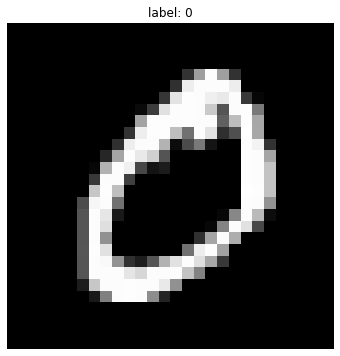

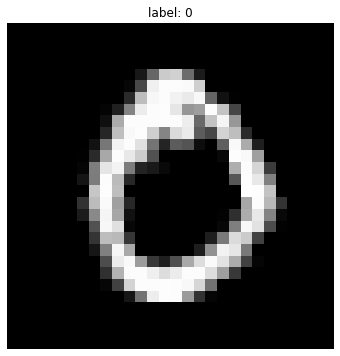

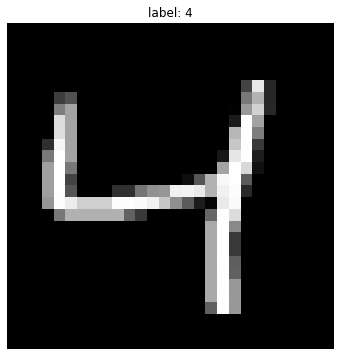

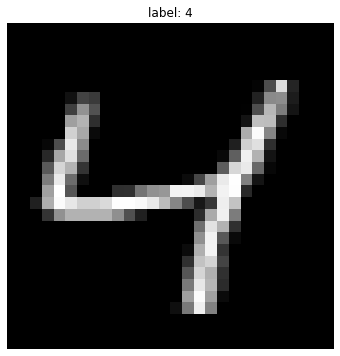

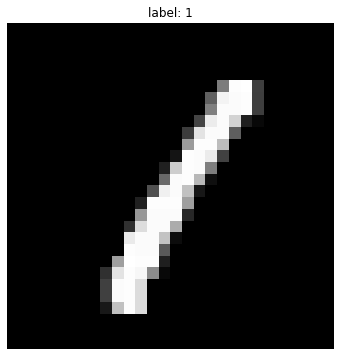

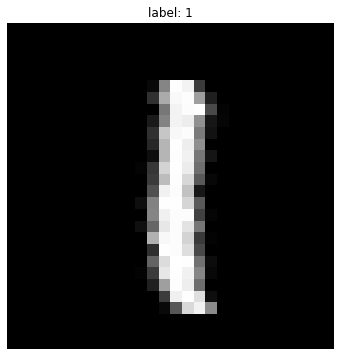

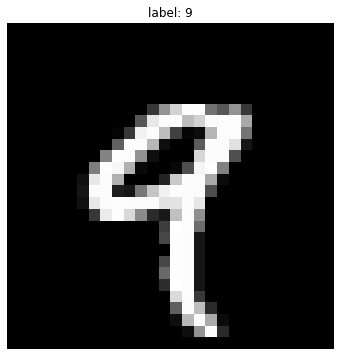

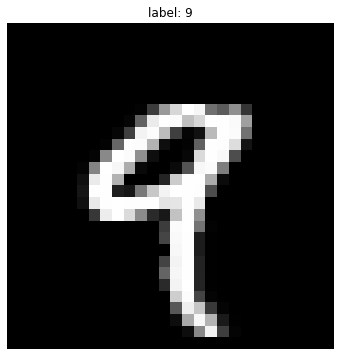

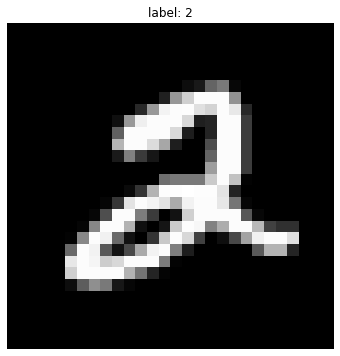

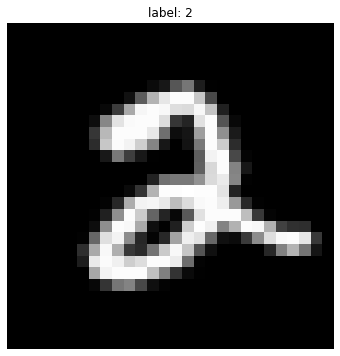

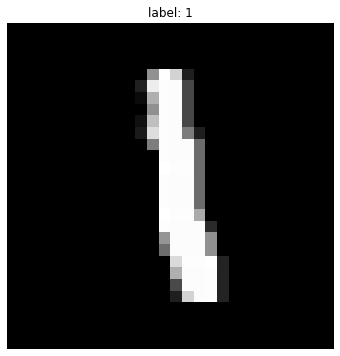

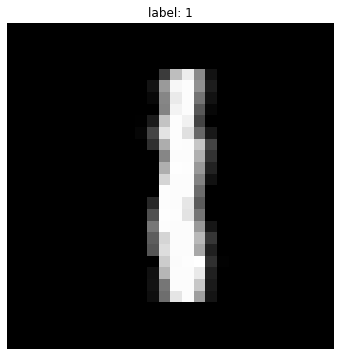

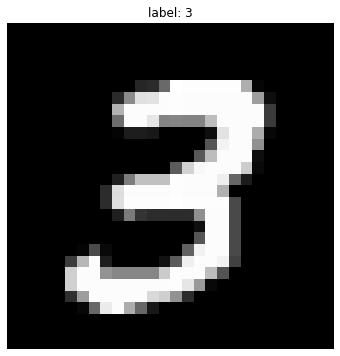

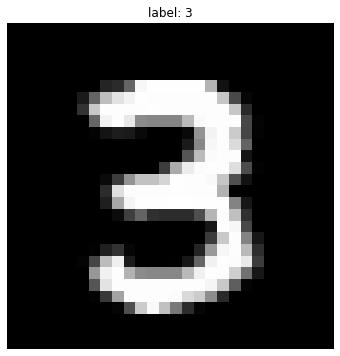

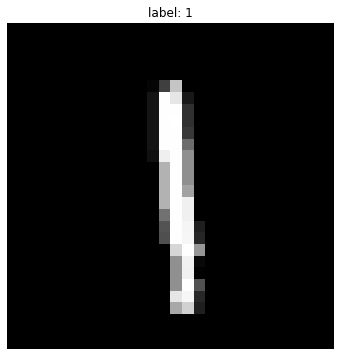

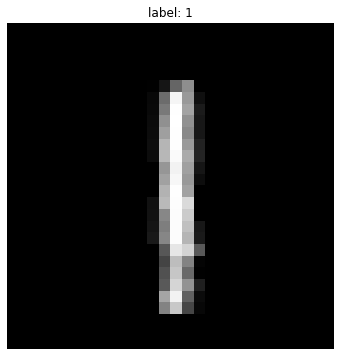

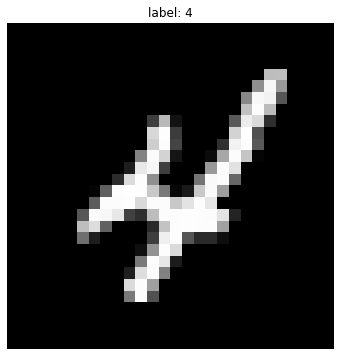

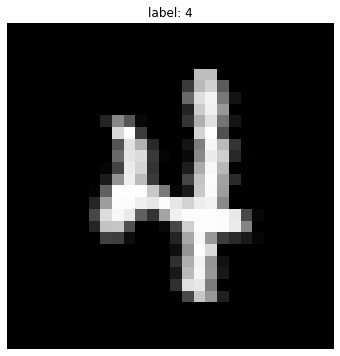

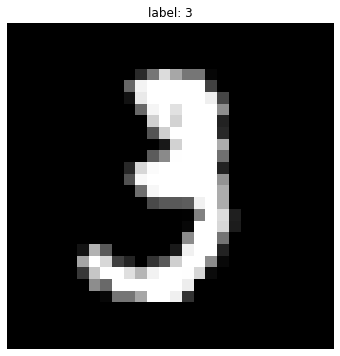

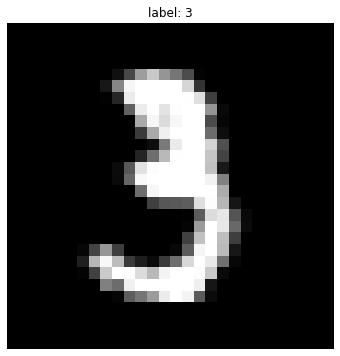

In [4]:
# prezentacja danych
print(train_images[0].shape)

# "prostowanie" cyfr
train_deskewed = np.asarray([deskew(im) for im in train_images])
test_deskewed = np.asarray([deskew(im) for im in test_images])

print(train_deskewed[0].shape)

# wyświetlanie rezultatu
for i in range(10):
    showOpencvImage(train_images[i+1], title=f"label: {train_labels[i+1]}")
    showOpencvImage(train_deskewed[i+1], title=f"label: {train_labels[i+1]}")

In [5]:
# HOG dla danych wyprostowanych

hog_train_deskewed = [openCVHOG(im) for im in train_deskewed]
hog_test_deskewed = [openCVHOG(im) for im in test_deskewed]
print("###########################################\nTrain:\n###########################################")
print(f"len(hog_train_deskewed): \t{len(hog_train_deskewed)}")
print(f"hog_train_deskewed[0].shape:\t{hog_train_deskewed[0].shape}")
train_data_deskewed = np.float32(hog_train_deskewed).reshape(-1,81)
print(f"train_data_deskewed.shape:\t{train_data_deskewed.shape}")
print("###########################################\nTest:\n###########################################")
print(f"len(hog_test_deskewed):  \t{len(hog_test_deskewed)}")
print(f"hog_test_deskewed[0].shape:\t{hog_test_deskewed[0].shape}")
test_data_deskewed = np.float32(hog_test_deskewed).reshape(-1,81)
print(f"test_data_deskewed.shape:\t{test_data_deskewed.shape}")

###########################################
Train:
###########################################
len(hog_train_deskewed): 	60000
hog_train_deskewed[0].shape:	(81,)
train_data_deskewed.shape:	(60000, 81)
###########################################
Test:
###########################################
len(hog_test_deskewed):  	10000
hog_test_deskewed[0].shape:	(81,)
test_data_deskewed.shape:	(10000, 81)


In [6]:
parameters = {'gamma':(0.5, 0.7, 0.9), 'C': np.linspace(start = 1, stop = 15, num = 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy', cv=StratifiedKFold())
clf.fit(train_data_deskewed[0:1000],train_labels[0:1000])
params = clf.best_params_
my_svc = clf.best_estimator_
print("Chosing params: ", params)

Chosing params:  {'C': 2.5555555555555554, 'gamma': 0.5}


In [7]:
# predykcja dla danych testowych
pred_labels = my_svc.predict(test_data_deskewed[0:1000,:])

In [8]:
# jakoś predykcji: dokładność

mask = pred_labels==test_labels[0:1000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

# macierz pomyłek oraz szczegółowy raport
cm = confusion_matrix(test_labels[0:1000], pred_labels)
print(cm)
print(classification_report(test_labels[0:1000], pred_labels))

92.9
[[ 81   0   0   0   1   0   0   0   0   3]
 [  0 125   0   0   0   0   0   1   0   0]
 [  0   0 110   0   0   1   2   3   0   0]
 [  0   0   3  96   0   5   0   0   2   1]
 [  0   0   0   0 106   0   2   1   0   1]
 [  0   0   0   0   1  84   1   1   0   0]
 [  0   0   0   0   1   1  85   0   0   0]
 [  1   0   5   6   0   0   0  84   1   2]
 [  1   0   3   1   1   2   2   0  72   7]
 [  0   0   0   0   3   1   1   0   3  86]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        85
           1       1.00      0.99      1.00       126
           2       0.91      0.95      0.93       116
           3       0.93      0.90      0.91       107
           4       0.94      0.96      0.95       110
           5       0.89      0.97      0.93        87
           6       0.91      0.98      0.94        87
           7       0.93      0.85      0.89        99
           8       0.92      0.81      0.86        89
           9       0.86

In [9]:
# analogicznie dla lasu losowego: tworzenie modelu -> szkolenie -> predykcja -> wyświetlanie rezultatów

parameters = {'n_estimators': range(10, 131, 30), 'max_depth': (10, 15, 25), 'criterion': ('gini', 'entropy')}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, scoring='accuracy', cv=StratifiedKFold())
clf.fit(train_data_deskewed[0:1000],train_labels[0:1000])
params = clf.best_params_
my_rfc = clf.best_estimator_
print("Chosing params: ", params)

# pred_labels = my_svc.predict(test_data[0:1000])

# rfc = RandomForestClassifier(max_depth=15, n_estimators=100, max_features=60)
# rfc = rfc.fit(train_data_deskewed[0:1000],train_labels[0:1000])

pred_labels = my_rfc.predict(test_data_deskewed[0:1000])

mask = pred_labels==test_labels[0:1000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels[0:1000], pred_labels)
print(cm)
print(classification_report(test_labels[0:1000], pred_labels))

Chosing params:  {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 130}
92.2
[[ 81   0   0   0   1   3   0   0   0   0]
 [  0 125   0   0   0   0   0   1   0   0]
 [  0   2 108   0   0   1   0   4   0   1]
 [  0   0   2 100   0   4   0   0   1   0]
 [  0   0   0   0 106   0   2   0   0   2]
 [  1   0   0   0   0  85   0   0   1   0]
 [  0   0   0   0   0   1  85   0   0   1]
 [  0   0   8   7   0   0   0  82   0   2]
 [  0   1   2   2   2   5   0   1  64  12]
 [  0   0   0   0   1   1   1   1   4  86]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        85
           1       0.98      0.99      0.98       126
           2       0.90      0.93      0.92       116
           3       0.92      0.93      0.93       107
           4       0.96      0.96      0.96       110
           5       0.85      0.98      0.91        87
           6       0.97      0.98      0.97        87
           7       0.92      0.83      0.87        99


### Klasyczne klasyfikatory (dane bez wyrównania)

In [10]:
# tym razem nie używamy funkccji deskew, nie wyrównujemy naszych cyfr

hog_train = [openCVHOG(im) for im in train_images]
hog_test = [openCVHOG(im) for im in test_images]
train_data = np.float32(hog_train).reshape(-1,81)
test_data = np.float32(hog_test).reshape(-1,81)

In [11]:
# postępujemy identycznie jak w przypadku danych z wyrównaniem

parameters = {'gamma':(0.5, 0.7, 0.9), 'C': np.linspace(start = 1, stop = 15, num = 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy', cv=StratifiedKFold())
clf.fit(train_data[0:1000],train_labels[0:1000])
params = clf.best_params_
my_svc = clf.best_estimator_
print("Chosing params: ", params)

pred_labels = my_svc.predict(test_data[0:1000])

mask = pred_labels==test_labels[0:1000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels[0:1000], pred_labels)
print(cm)
print(classification_report(test_labels[0:1000], pred_labels))

Chosing params:  {'C': 4.111111111111111, 'gamma': 0.5}
93.6
[[ 80   0   0   0   1   1   0   0   0   3]
 [  0 125   1   0   0   0   0   0   0   0]
 [  0   0 109   0   0   0   2   4   0   1]
 [  0   0   2  99   0   4   0   1   1   0]
 [  0   1   0   0 106   0   3   0   0   0]
 [  0   1   0   0   0  85   0   1   0   0]
 [  1   0   0   0   1   0  83   0   2   0]
 [  0   0   3   7   0   1   0  87   0   1]
 [  1   0   2   3   1   3   0   1  73   5]
 [  0   0   0   0   0   1   0   1   3  89]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        85
           1       0.98      0.99      0.99       126
           2       0.93      0.94      0.94       116
           3       0.91      0.93      0.92       107
           4       0.97      0.96      0.97       110
           5       0.89      0.98      0.93        87
           6       0.94      0.95      0.95        87
           7       0.92      0.88      0.90        99
           8       0.

In [12]:
# tak samo dla lasu losowego

parameters = {'n_estimators': range(10, 131, 30), 'max_depth': (10, 15, 25), 'criterion': ('gini', 'entropy')}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, scoring='accuracy', cv=StratifiedKFold())
clf.fit(train_data[0:1000],train_labels[0:1000])
params = clf.best_params_
my_rfc = clf.best_estimator_
print("Chosing params: ", params)

pred_labels = my_rfc.predict(test_data[0:1000])

mask = pred_labels==test_labels[0:1000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels[0:1000], pred_labels)
print(cm)
print(classification_report(test_labels[0:1000], pred_labels))

Chosing params:  {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
90.0
[[ 82   0   0   0   1   2   0   0   0   0]
 [  0 125   0   0   0   0   0   1   0   0]
 [  0   0  98   5   0   0   2   9   0   2]
 [  0   0   1 100   0   5   0   0   1   0]
 [  0   0   0   0 102   0   5   0   1   2]
 [  0   0   0   1   0  84   0   0   2   0]
 [  2   0   0   0   4   2  78   0   1   0]
 [  1   0   3  10   0   1   0  83   0   1]
 [  3   0   3   3   1   4   0   0  64  11]
 [  1   0   0   0   2   0   1   1   5  84]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        85
           1       1.00      0.99      1.00       126
           2       0.93      0.84      0.89       116
           3       0.84      0.93      0.88       107
           4       0.93      0.93      0.93       110
           5       0.86      0.97      0.91        87
           6       0.91      0.90      0.90        87
           7       0.88      0.84      0.86        

## Wnioski:
Nie wiem

### Sieci neuronowe (dane z wyrównaniem)

In [13]:
# Tworzenie modelu oraz dodanie dwóch warstw

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(81,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [14]:
test_hog_deskewed = np.array(np.float32([openCVHOG(deskew(im)) for im in test_images]).reshape(-1,81)).astype('float32') / 255
train_hog_deskewed = np.array(np.float32([openCVHOG(deskew(im)) for im in train_images]).reshape(-1,81)).astype('float32') / 255

In [15]:
encoded_train_labels = to_categorical(train_labels)
encoded_test_labels = to_categorical(test_labels)

encoded_test_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
network.fit(train_hog_deskewed, encoded_train_labels, epochs=15, batch_size=128)

Epoch 1/15
469/469 [==============================] - 1s 1ms/step - loss: 2.2536 - accuracy: 0.2101
Epoch 2/15
469/469 [==============================] - 1s 1ms/step - loss: 1.8217 - accuracy: 0.5442
Epoch 3/15
469/469 [==============================] - 1s 1ms/step - loss: 1.3687 - accuracy: 0.6923
Epoch 4/15
469/469 [==============================] - 1s 1ms/step - loss: 1.0426 - accuracy: 0.7645
Epoch 5/15
469/469 [==============================] - 1s 1ms/step - loss: 0.7952 - accuracy: 0.8141
Epoch 6/15
469/469 [==============================] - 1s 1ms/step - loss: 0.6318 - accuracy: 0.8431
Epoch 7/15
469/469 [==============================] - 1s 1ms/step - loss: 0.5123 - accuracy: 0.8679
Epoch 8/15
469/469 [==============================] - 1s 1ms/step - loss: 0.4336 - accuracy: 0.8853
Epoch 9/15
469/469 [==============================] - 1s 1ms/step - loss: 0.3803 - accuracy: 0.8962
Epoch 10/15
469/469 [==============================] - 1s 1ms/step - loss: 0.3386 - accuracy: 0.9069

In [17]:
test_loss, test_acc = network.evaluate(test_hog_deskewed, encoded_test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 735us/step - loss: 0.2032 - accuracy: 0.9398
test_acc: 0.9398000240325928


In [18]:
pred_probabilities = network.predict(test_hog_deskewed)
print(pred_probabilities[0:1])

[[2.1124902e-09 5.4580003e-05 2.9317208e-04 1.0227526e-03 3.0345756e-08
  5.6496519e-09 9.9862061e-16 9.9860919e-01 9.5329979e-06 1.0749714e-05]]


In [19]:
pred_labels = np.argmax(pred_probabilities,-1)

print(f"Accuracy score for deskewed data: {accuracy_score(test_labels, pred_labels)}\n")
print(confusion_matrix(test_labels, pred_labels))
print(classification_report(test_labels, pred_labels))

Accuracy score for deskewed data: 0.9398

[[ 947    1    6    0    1    3    7    1    1   13]
 [   1 1122    2    0    4    0    2    3    1    0]
 [   0    3  969   14    2    0    1   32    9    2]
 [   0    1   16  956    0    8    0   16   11    2]
 [   2    5    3    0  946    1   13    1    3    8]
 [   3    0    1    7    3  839    4    1   24   10]
 [   7    3    1    0   14    4  926    0    3    0]
 [   6    4   40   34    3    0    0  925    5   11]
 [   1    0    5   12   14    7    5    4  890   36]
 [  16    1    5    3    8   14    8   24   52  878]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.98      0.99      0.99      1135
           2       0.92      0.94      0.93      1032
           3       0.93      0.95      0.94      1010
           4       0.95      0.96      0.96       982
           5       0.96      0.94      0.95       892
           6       0.96      0.97      0.96     

### Sieci neuronowe (dane bez wyrównania)

In [20]:
test_hog_nondeskewed = np.array(np.float32([openCVHOG(im) for im in test_images]).reshape(-1,81)).astype('float32') / 255
train_hog_nondeskewed = np.array(np.float32([openCVHOG(im) for im in train_images]).reshape(-1,81)).astype('float32') / 255

In [21]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(81,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [22]:
network.fit(train_hog_nondeskewed, encoded_train_labels, epochs=15, batch_size=128)

Epoch 1/15
469/469 [==============================] - 1s 1ms/step - loss: 2.2613 - accuracy: 0.1970
Epoch 2/15
469/469 [==============================] - 1s 1ms/step - loss: 1.8816 - accuracy: 0.4927
Epoch 3/15
469/469 [==============================] - 1s 1ms/step - loss: 1.4613 - accuracy: 0.6472
Epoch 4/15
469/469 [==============================] - 1s 1ms/step - loss: 1.1429 - accuracy: 0.7202
Epoch 5/15
469/469 [==============================] - 1s 1ms/step - loss: 0.9109 - accuracy: 0.7690
Epoch 6/15
469/469 [==============================] - 1s 1ms/step - loss: 0.7492 - accuracy: 0.8009
Epoch 7/15
469/469 [==============================] - 1s 1ms/step - loss: 0.6362 - accuracy: 0.8267
Epoch 8/15
469/469 [==============================] - 1s 1ms/step - loss: 0.5543 - accuracy: 0.8456
Epoch 9/15
469/469 [==============================] - 1s 1ms/step - loss: 0.4968 - accuracy: 0.8602
Epoch 10/15
469/469 [==============================] - 1s 1ms/step - loss: 0.4511 - accuracy: 0.8727

In [23]:
test_loss, test_acc = network.evaluate(test_hog_nondeskewed, encoded_test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 684us/step - loss: 0.2847 - accuracy: 0.9208
test_acc: 0.920799970626831


In [24]:
pred_probabilities = network.predict(test_hog_nondeskewed)
pred_labels = np.argmax(pred_probabilities,-1)

print(f"Accuracy score for deskewed data: {accuracy_score(test_labels, pred_labels)}\n")
print(confusion_matrix(test_labels, pred_labels))
print(classification_report(test_labels, pred_labels))

Accuracy score for deskewed data: 0.9208

[[ 941    2   10    0    2    5    9    0    2    9]
 [   0 1120    3    0    2    0    1    2    6    1]
 [   3    2  982    7    0    0    0   29    9    0]
 [   0    0   35  935    0    6    0   13   19    2]
 [   6    3    3    0  923    1   23    0   11   12]
 [   3    1    3   22    1  777    1    1   68   15]
 [  20    4    2    0   11    7  905    0    8    1]
 [   7    4   81   29    1    0    0  885    8   13]
 [   6    4   18   19    6    6    7    7  861   40]
 [  32    3    1    4    3   12    1   17   57  879]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.98      0.99      0.98      1135
           2       0.86      0.95      0.91      1032
           3       0.92      0.93      0.92      1010
           4       0.97      0.94      0.96       982
           5       0.95      0.87      0.91       892
           6       0.96      0.94      0.95     

### Zadanie 3 - dane surowe vs hog

In [25]:
test_hog_deskewed = np.array(np.float32([openCVHOG(deskew(im)) for im in test_images]).reshape(-1,81)).astype('float32')
train_hog_deskewed = np.array(np.float32([openCVHOG(deskew(im)) for im in train_images]).reshape(-1,81)).astype('float32')

test_deskewed = np.array(np.float32([deskew(im) for im in test_images]).reshape(-1,784)).astype('float32')
train_deskewed = np.array(np.float32([deskew(im) for im in train_images]).reshape(-1,28*28)).astype('float32')

In [26]:
train_images1 = train_images
train_images1 = (train_images.astype('float32') / 255).reshape((60000, 784))

test_images1 = test_images
test_images1 = (test_images.astype('float32') / 255).reshape((-1, 784))

In [27]:
model_hog = svm.SVC(C=15.5,gamma=0.7)
model_hog.fit(train_hog_deskewed[0:1000],train_labels[0:1000])

pred_labels_hog = model_hog.predict(test_hog_deskewed[0:1000])

model = svm.SVC(C=15.5,gamma=0.7)
model.fit(train_images1[0:1000],train_labels[0:1000])

pred_labels = model.predict(test_images1[0:1000])

In [28]:
print(f"accuracy: {accuracy_score(test_labels[0:1000], pred_labels_hog)}")
print(confusion_matrix(test_labels[0:1000], pred_labels_hog))
print(classification_report(test_labels[0:1000], pred_labels_hog))

print(f"accuracy: {accuracy_score(test_labels[0:1000], pred_labels)}")
print(confusion_matrix(test_labels[0:1000], pred_labels))
print(classification_report(test_labels[0:1000], pred_labels))

accuracy: 0.932
[[ 81   0   0   0   1   0   0   0   0   3]
 [  0 125   0   0   0   0   0   1   0   0]
 [  0   0 110   0   0   0   2   3   0   1]
 [  0   0   2  97   0   5   0   0   2   1]
 [  0   0   0   0 108   0   1   1   0   0]
 [  0   0   0   0   1  84   1   1   0   0]
 [  0   0   0   0   2   1  84   0   0   0]
 [  1   0   5   6   0   1   0  84   0   2]
 [  1   0   3   1   1   2   2   0  73   6]
 [  0   0   0   0   3   1   1   0   3  86]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        85
           1       1.00      0.99      1.00       126
           2       0.92      0.95      0.93       116
           3       0.93      0.91      0.92       107
           4       0.93      0.98      0.96       110
           5       0.89      0.97      0.93        87
           6       0.92      0.97      0.94        87
           7       0.93      0.85      0.89        99
           8       0.94      0.82      0.87        89
           9

D:\programy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
